In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import plotly.graph_objects as go
import plotly.io as pio
import math

from scipy.stats import wilcoxon
import pingouin as pg

rcParams = {
    'axes.titlesize': 30,
    'axes.labelsize': 28,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 16,
    'lines.linewidth': 2,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial']
}
sns.set_context("paper", font_scale=2, rc=rcParams)

In [2]:
# Get the colorblind palette
colorblind_palette = sns.color_palette("colorblind", n_colors=5)

method_colors = {
    'THOI': colorblind_palette[0],
    'HOI_toolbox': colorblind_palette[2],
    'HOI': colorblind_palette[4],
    #'GCMI': colorblind_palette[4],
    # 'NPEET': colorblind_palette[1],
    'JIDT': colorblind_palette[3]
}

In [3]:
def estimated_computation_time(time_order_5, order):
    # assumes a system of 30 variables and 100000 samples
    nplet_time = time_order_5 / math.comb(30,5)
    return math.comb(30, order) * nplet_time


def get_quituplet_time_from_df(df, library, estimator):
    return df[(df.library == library) & (df.estimator == estimator) & (df['T'] == 1000) & (df.order == 5)]['time'].values[0]


def plot_estimated_computation_times(df, ax):
    
    quintuplet_times = {
        'HOI_toolbox': get_quituplet_time_from_df(df, 'HOI_toolbox', 'GC'),
        'HOI': get_quituplet_time_from_df(df, 'HOI', 'GC'),
        #'GCMI': get_quituplet_time_from_df(df, 'GCMI', 'GC'),
        #'NPEET': get_quituplet_time_from_df(df, 'NPEET', 'KSG'),
        'JIDT': get_quituplet_time_from_df(df, 'JIDT', 'KSG')
    }

    dfs = []
    for library, tuple_t in quintuplet_times.items():
        df = pd.DataFrame({
            'time': [estimated_computation_time(tuple_t,k) for k in range(3,31)],
            'order': list(range(3,31))
        })
        df['library'] = library
        df['T'] = 1000
        df['N'] = 30
        dfs.append(df)

    # Combine all dataframes into one
    df = pd.concat(dfs, ignore_index=True)
    df['time'] = df['time']

    # Create a line plot using Seaborn
    ax = sns.lineplot(
        data=df, x="order", y="time",
        hue="library", style='library',
        markers=True, dashes=False, ax=ax,
        palette=method_colors
    )

    ax.set_xlabel('Order or interactions')
    ax.set_ylabel('Time (Hs)')
    ax.legend(title='Library')
    ax.grid(True)

    for library in quintuplet_times.keys():
        print(library)
        df_lib = df[(df.library == library)]
        print('time order 15:', math.floor(df_lib[df_lib.order == 15]['time'].values[0]), 'days')
        print('time all orders:', math.floor(df_lib['time'].sum()))

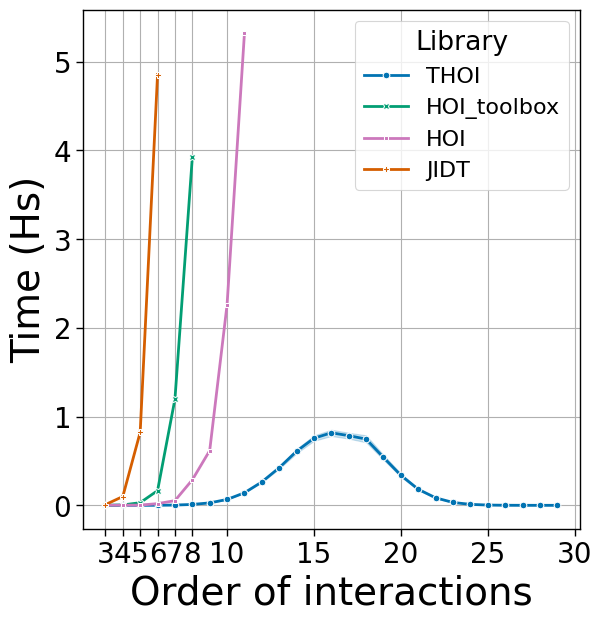

HOI_toolbox
time order 15: 32 days
time all orders: 221
HOI
time order 15: 2 days
time all orders: 18
JIDT
time order 15: 895 days
time all orders: 6201


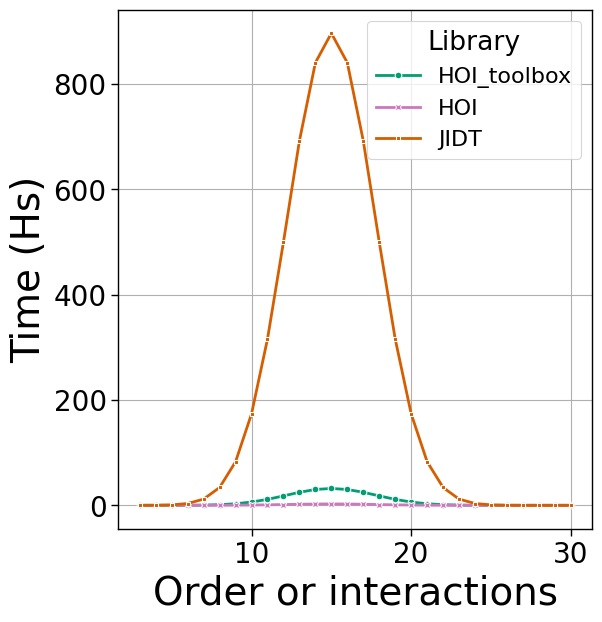

In [4]:
# Define the file paths
file_paths = [
    "library-thoi_estimator-gc_device-cpu_indexing-indexes.tsv",
    "library-hoitoolbox_estimator-gc.tsv",
    "library-hoi_estimator-gc.tsv",
    #"library-gcmi_estimator-gc.tsv",
    #"library-npeet_estimator-ksg.tsv",
    "library-jdit_estimator-ksg.tsv"
]

# Read each file into a DataFrame and assign a 'Method' column
dataframes = []
for path in file_paths:
    df = pd.read_csv(os.path.join('../benchmarking/results/times/',path), sep="\t")
    dataframes.append(df)


# Combine all dataframes into one
combined_df = pd.concat(dataframes, ignore_index=True)
combined_df['time'] = combined_df['time'] / 60 / 60

# Filter the N != 30 rows
combined_df = combined_df[combined_df.N == 30]

#########################################

fig, ax = plt.subplots(figsize=(6.4, 6.6))

sns.lineplot(
    data=combined_df, x="order", y="time",
    hue="library", style='library',
    markers=True, dashes=False, ax=ax,
    palette=method_colors
)
ax.set_xticks([3,4,5,6,7,8,10,15,20,25,30])

ax.set_xlabel('Order of interactions')
ax.set_ylabel('Time (Hs)')
ax.legend(title='Library')
ax.grid(True)

plt.tight_layout()
plt.savefig('./figures/times/benchmarking_times.pdf', format='pdf')
plt.show()

#############################################

fig, ax = plt.subplots(figsize=(6.4, 6.6))

plot_estimated_computation_times(combined_df, ax)

plt.tight_layout()
plt.savefig('./figures/times/benchmarking_estimated_times.pdf', format='pdf')
plt.show()

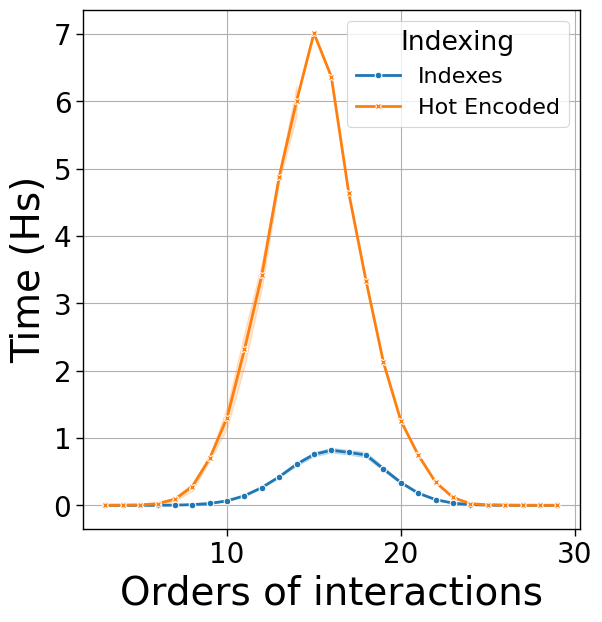

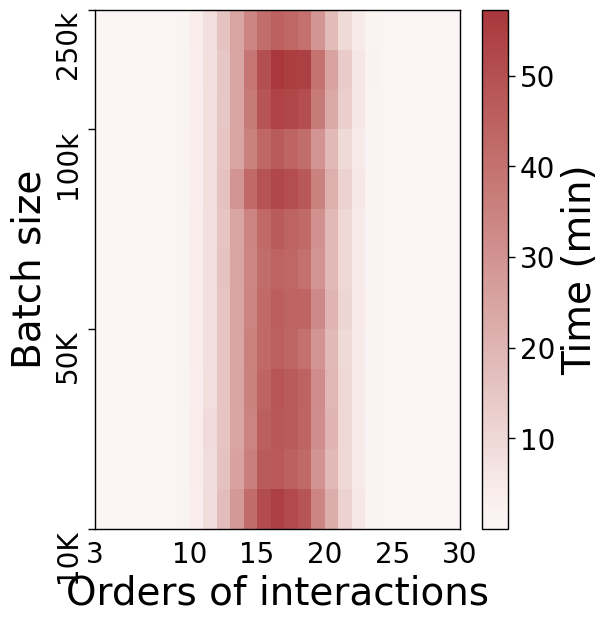

/tmp/ipykernel_79577/38087771.py:129: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{int(x/1000)}K' for x in total_time_table['batch_size']])


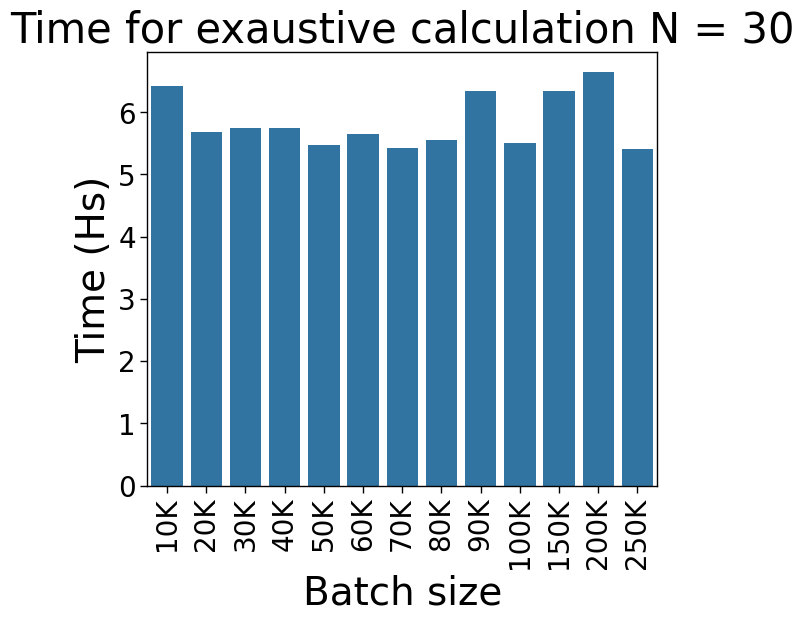

In [5]:
colorblind_palette = sns.color_palette("colorblind", n_colors=5)

indexing_colors = {
    'Indexes': colorblind_palette[0],
    'Hot Encoded': colorblind_palette[2]
}

# Define the file paths
file_paths = [
    "library-thoi_estimator-gc_device-cpu_indexing-indexes.tsv",
    "library-thoi_estimator-gc_device-cpu_indexing-hotencoded.tsv"
]

# Read each file into a DataFrame and assign a 'Method' column
dataframes = []
for path, indexing in zip(file_paths, list(indexing_colors.keys())):
    df = pd.read_csv(os.path.join('../benchmarking/results/times/',path), sep="\t")
    #df['indexing-N'] = indexing + '-' + df['N'].astype(str)
    df['indexing'] = indexing
    dataframes.append(df)

# Combine all dataframes into one
combined_df = pd.concat(dataframes, ignore_index=True)
combined_df.loc[:,'time'] = combined_df.loc[:,'time'] / 60 / 60

# Filter executions with N != 30
N = 30
combined_df = combined_df[combined_df.N == N]

#########################################

fig, ax = plt.subplots(figsize=(6.4, 6.6))

sns.lineplot(
    data=combined_df, x="order", y="time",
    hue="indexing", style='indexing',
    markers=True, dashes=False,
    ax=ax
    #palette=indexing_colors
)

ax.set_xlabel('Orders of interactions')
ax.set_ylabel('Time (Hs)')
ax.legend(title='Indexing')
ax.grid(True)

plt.tight_layout()
plt.savefig('./figures/times/benchmarking_indexes_vs_hotencoded.pdf', format='pdf')
plt.show()


#########################################

import numpy as np
from matplotlib.colors import ListedColormap

full_cmap = sns.color_palette("vlag", as_cmap=True)
num_colors = 256
colors = full_cmap(np.linspace(0.2, 0.85, num_colors))
half_cmap = ListedColormap(colors)

for indexing in ['Indexes']: # , 'Hot Encoded'
    
    fig, ax = plt.subplots(figsize=(6.4, 6.6))

    df_indexes = combined_df[(combined_df.indexing == indexing)]
    df_indexes.loc[:,'time'] = df_indexes.loc[:,'time'] * 60 # convert to minutes

    # Pivot the data to get a matrix form suitable for heatmap plotting
    order_batch_size_table = df_indexes.pivot(columns='order', index='batch_size', values="time")
    
    # Create the heatmap
    ax = sns.heatmap(
        order_batch_size_table, cmap='vlag', center=0,
        annot=False, cbar=False, ax=ax,
    )

    # set the x-axis labels
    ax.tick_params(axis='x', rotation=90, left=False, bottom=False)
    ax.set_xlabel('Orders of interactions')
    ax.set_xticks([0,7,12,17,22,27])
    ax.set_xticklabels([3,10,15,20,25,30], rotation=0)

    # set the y-axis labels
    ax.set_yticks([0,5,10,13])
    ax.set_yticklabels(['10K', '50K', '100k', '250k'], rotation=90, ha='center', va='top')
    ax.tick_params(axis='y', pad=15)
    ax.set_ylabel('Batch size')
    ax.yaxis.tick_left()
    ax.yaxis.set_label_position("left")
    
    # revert y-axis direction
    ax.invert_yaxis()

    # add border to the heatmap
    for _, spine in ax.spines.items():
        spine.set_visible(True)
    
    #ax_total.set_xticklabels(['Total time'], rotation=90, ha='center', va='top')

    # Create the colorbar and set it to the left
    cbar = ax.figure.colorbar(ax.collections[0], ax=ax, location='right')
    cbar.set_label('Time (min)')
    
    # move cbar more to the right
    cbar.ax.yaxis.set_label_position('right')

    #plt.title(indexing)

    plt.tight_layout()
    plt.savefig(f'./figures/times/benchmarking_batch_size_vs_order_{indexing.lower().replace(" ","_")}.pdf', format='pdf')
    plt.show()
    
    
    
    # suplemental total time per order
    total_time_table = order_batch_size_table.sum(axis=1).to_frame().reset_index()
    total_time_table[0] = total_time_table[0] / 60 # convert to hours
    
    # plot bar plot x = order, y = total time
    fig, ax = plt.subplots(figsize=(6.4, 6.6))
    
    sns.barplot(x='batch_size', y=0, data=total_time_table, ax=ax)
    
    # Rotate x labels to make them readable
    plt.xticks(rotation=90)
    
    # make tiks from numbers to xxxK strings to represent thousands
    ax.set_xticklabels([f'{int(x/1000)}K' for x in total_time_table['batch_size']])
    
    plt.xlabel('Batch size')
    plt.ylabel('Time (Hs)')
    plt.title('Time for exaustive calculation N = 30')
    
    plt.tight_layout()
    plt.show()

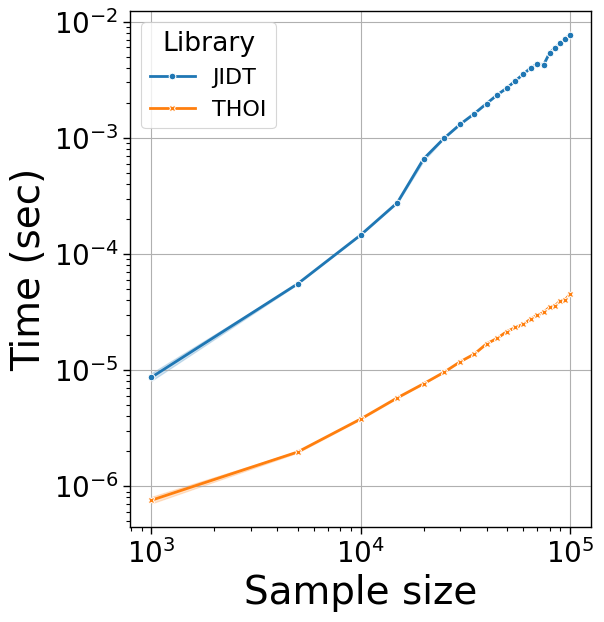

In [6]:
file_paths = [
    "by_sample_size_library-jidt.tsv",
    "by_sample_size_library-thoi.tsv",
]

libraries = [
    'JIDT',
    'THOI'
]

# Read each file into a DataFrame and assign a 'Method' column
dataframes = []
for path, library in zip(file_paths, list(libraries)):
    df = pd.read_csv(os.path.join('../benchmarking/results/times/', path), sep='\t')
    df['library'] = library
    dataframes.append(df)

# TODO: Check if times are in the same units or not

# Combine all dataframes into one
combined_df = pd.concat(dataframes, ignore_index=True)
combined_df['time'] = combined_df['time'] / 60 / 60

# plot
fig, ax = plt.subplots(figsize=(6.4, 6.6))

sns.lineplot(
    data=combined_df, x="sample size", y="time",
    hue="library", style='library',
    markers=True, dashes=False, ax=ax,
    #palette=indexing_colors
)

# set x scale to log
ax.set_xscale('log')
ax.set_yscale('log')


ax.set_xlabel('Sample size')
ax.set_ylabel('Time (sec)')
ax.legend(title='Library')
ax.grid(True)

plt.tight_layout()
plt.savefig('./figures/times/benchmarking_by_sample_size_thoi_vs_jidt.pdf', format='pdf')
plt.show()

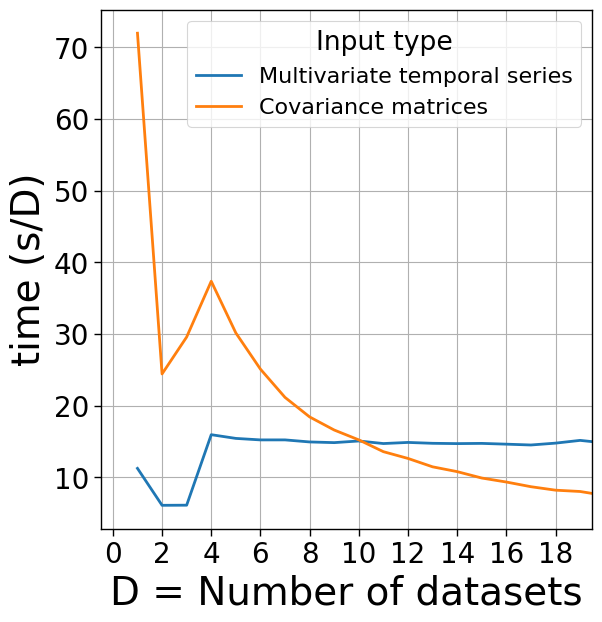

In [7]:
df = pd.read_csv('/home/laouen.belloli/Documents/git/Oinformation/benchmarking/results/times/single_vs_listed_datasets.tsv', sep='\t')

df['time'] = df['time'] / df['D']
df = df.sort_values(by='D')
df['input_type'] = df['input_type'].replace({
    'timeseries': 'Multivariate temporal series',
    'covmat': 'Covariance matrices'
})
df['D'] = df['D'].astype(int)

fig, ax = plt.subplots(figsize=(6.4, 6.6))

# Plot violin plots of the best nplets with state in the x acess and o in the y axis
sns.lineplot(
    data=df, x='D', y='time',
    hue='input_type', ax=ax)


#ax.set_title(f'p-value: {pval:.2e} - Effect size: {effect_size:.2f}', fontsize=14)
ax.set_xlabel('D = Number of datasets')
ax.set_ylabel('time (s/D)')

# change legend label
ax.legend(title='Input type')

# make x axis only integers
ax.xaxis.set_major_locator(plt.MaxNLocator(10))

plt.xlim(-0.5, len(df['D'].unique()) - 0.5)

ax.grid(True)
plt.tight_layout()
plt.savefig('./figures/times/benchmarking_by_D.pdf', format='pdf')
plt.show()

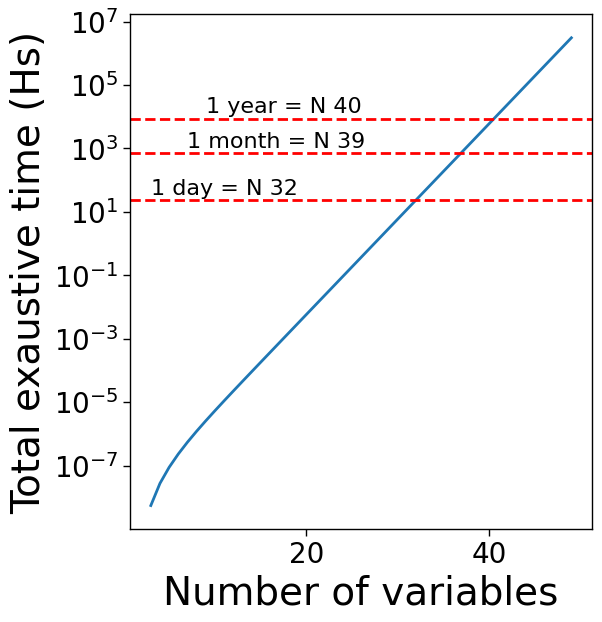

In [9]:
def estimated_computation_time(time, new_order, new_N, curr_order=15, curr_N=30):
    nplet_time = time / math.comb(curr_N,curr_order)
    return math.comb(new_N, new_order) * nplet_time

df = pd.read_csv('/home/laouen.belloli/Documents/git/Oinformation/benchmarking/results/times/library-thoi_estimator-gc_device-cpu_indexing-indexes.tsv', sep='\t')
df = df[(df['N'] == 30) & (df['T'] == 1000) & (df['order'] == 15) & (df['batch_size'] == 10000)]
time = df['time'].values[0]

x = [n for n in range(3,50)]
y = np.array([np.sum([estimated_computation_time(time, o, n) for o in range(3,n+1)]) for n in x]) / 60 / 60

fig, ax = plt.subplots(figsize=(6.4, 6.6))

sns.lineplot(x=x, y=y, ax=ax)

plt.yscale('log')

# set horizonal lines for 1 day and 1 week 1 month and 1 year with texts over the lines
plt.axhline(y=24, color='r', linestyle='--')
plt.text(3, 24*1.5, f'1 day = N {x[np.where(y < 24)[0][-1]]}', color='black', fontsize=16)
#plt.axhline(y=24*7, color='r', linestyle='--')
#plt.text(5, 24*7*1.2, f'1 week = N {x[np.where(y < 24*7)[0][-1]]}', color='black', fontsize=16)
plt.axhline(y=24*30, color='r', linestyle='--')
plt.text(7, 24*30*1.5, f'1 month = N {x[np.where(y < 24*30*7)[0][-1]]}', color='black', fontsize=16)
plt.axhline(y=24*365, color='r', linestyle='--')
plt.text(9, 24*365*1.5, f'1 year = N {x[np.where(y < 24*365)[0][-1]]}', color='black', fontsize=16)

plt.xlabel('Number of variables')
plt.ylabel('Total exaustive time (Hs)')

plt.tight_layout()
plt.savefig('./figures/times/benchmarking_estimated_total_time_by_N.pdf', format='pdf')
plt.show()